# Universal Strategy Analysis

This notebook provides comprehensive analysis across all strategies tested in a parameter sweep.

**Key Features:**
- Cross-strategy performance comparison
- Parameter sensitivity analysis
- Correlation analysis for ensemble building
- Regime-specific performance breakdown
- Automatic identification of optimal strategies and ensembles

In [1]:
# Parameters will be injected here by papermill
# This cell is tagged with 'parameters' for papermill to recognize it
run_dir = "."
config_name = "config"
symbols = ["SPY"]
timeframe = "5m"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True  # Set to False to limit analysis for large sweeps
performance_limit = 100  # If calculate_all_performance is False, limit to this many

In [2]:
# Parameters
run_dir = "/Users/daws/ADMF-PC/config/bollinger/results/20250625_110026"
config_name = "bollinger"
symbols = ["SPY_5m"]
timeframe = "5m"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True
performance_limit = 100


## Setup

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import duckdb
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Initialize DuckDB
con = duckdb.connect()

# Convert run_dir to Path and resolve to absolute path
run_dir = Path(run_dir).resolve()
print(f"Analyzing run: {run_dir.name}")
print(f"Full path: {run_dir}")
print(f"Config: {config_name}")
print(f"Symbol(s): {symbols}")
print(f"Timeframe: {timeframe}")

Analyzing run: 20250625_110026
Full path: /Users/daws/ADMF-PC/config/bollinger/results/20250625_110026
Config: bollinger
Symbol(s): ['SPY_5m']
Timeframe: 5m


In [4]:
# Setup path for loading analysis snippets
import sys
from pathlib import Path

# Find the project root (where src/ directory is)
current_path = Path(run_dir).resolve()
project_root = None

# Search up the directory tree for src/analytics/snippets
for parent in current_path.parents:
    if (parent / 'src' / 'analytics' / 'snippets').exists():
        project_root = parent
        break

# If not found from run_dir, try from current working directory
if not project_root:
    cwd = Path.cwd()
    for parent in [cwd] + list(cwd.parents):
        if (parent / 'src' / 'analytics' / 'snippets').exists():
            project_root = parent
            break

# Last resort: check common project locations
if not project_root:
    common_roots = [
        Path('/Users/daws/ADMF-PC'),
        Path.home() / 'ADMF-PC',
        Path.cwd().parent.parent.parent.parent  # 4 levels up from typical results dir
    ]
    for root in common_roots:
        if root.exists() and (root / 'src' / 'analytics' / 'snippets').exists():
            project_root = root
            break

if project_root:
    # Add to Python path if not already there
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    snippets_path = project_root / 'src' / 'analytics' / 'snippets'
    queries_path = project_root / 'src' / 'analytics' / 'queries'
    print(f"✅ Found project root: {project_root}")
    print(f"✅ Analysis snippets available at: {snippets_path}")
    print(f"✅ SQL queries available at: {queries_path}")
    print("\nUse %load to load any snippet, e.g.:")
    print("  %load {}/src/analytics/snippets/exploratory/signal_frequency.py".format(project_root))
    print("  %load {}/src/analytics/snippets/ensembles/find_uncorrelated.py".format(project_root))
else:
    print("⚠️ Could not find project root with src/analytics/snippets")
    print(f"  Searched from: {current_path}")
    print(f"  Current working directory: {Path.cwd()}")

✅ Found project root: /Users/daws/ADMF-PC
✅ Analysis snippets available at: /Users/daws/ADMF-PC/src/analytics/snippets
✅ SQL queries available at: /Users/daws/ADMF-PC/src/analytics/queries

Use %load to load any snippet, e.g.:
  %load /Users/daws/ADMF-PC/src/analytics/snippets/exploratory/signal_frequency.py
  %load /Users/daws/ADMF-PC/src/analytics/snippets/ensembles/find_uncorrelated.py


## Load Strategy Index

In [5]:
# Load strategy index - the catalog of all strategies tested
strategy_index_path = run_dir / 'strategy_index.parquet'

if strategy_index_path.exists():
    strategy_index = pd.read_parquet(strategy_index_path)
    print(f"✅ Loaded {len(strategy_index)} strategies from {strategy_index_path}")
    
    # Show strategy type distribution
    by_type = strategy_index['strategy_type'].value_counts()
    print("\nStrategies by type:")
    for stype, count in by_type.items():
        print(f"  {stype}: {count}")
        
    # Show sample of columns
    print(f"\nColumns: {list(strategy_index.columns)[:10]}...")
else:
    print(f"❌ No strategy_index.parquet found at {strategy_index_path}")
    strategy_index = None

✅ Loaded 205 strategies from /Users/daws/ADMF-PC/config/bollinger/results/20250625_110026/strategy_index.parquet

Strategies by type:
  bollinger_bands: 205

Columns: ['strategy_id', 'strategy_hash', 'strategy_type', 'symbol', 'timeframe', 'constraints', 'trace_path']...


## Performance Calculation

In [6]:
def calculate_performance(strategy_hash, trace_path, market_data):
    """Calculate performance metrics for a strategy"""
    try:
        # Always use the global run_dir which is already resolved to absolute path
        signals_path = run_dir / trace_path
            
        # Load sparse signals
        signals = pd.read_parquet(signals_path)
        signals['ts'] = pd.to_datetime(signals['ts'])
        
        # Merge with market data
        df = market_data.merge(
            signals[['ts', 'val']], 
            left_on='timestamp', 
            right_on='ts', 
            how='left'
        )
        
        # Forward fill signals (sparse to dense)
        df['signal'] = df['val'].ffill().fillna(0)
        
        # Calculate returns
        df['returns'] = df['close'].pct_change()
        df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
        df['cum_returns'] = (1 + df['strategy_returns']).cumprod()
        
        # Metrics
        total_return = df['cum_returns'].iloc[-1] - 1
        
        if df['strategy_returns'].std() > 0:
            sharpe = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252 * 78)
        else:
            sharpe = 0
            
        cummax = df['cum_returns'].expanding().max()
        drawdown = (df['cum_returns'] / cummax - 1)
        max_dd = drawdown.min()
        
        # Count trades
        trades = (df['signal'] != df['signal'].shift()).sum()
        
        return {
            'total_return': total_return,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd,
            'num_trades': trades,
            'df': df  # For later analysis
        }
    except Exception as e:
        print(f"Error calculating performance for {strategy_hash}: {e}")
        return None

In [7]:
# Load market data
# First, try to create a symlink to data directory for easier access
try:
    data_symlink = Path('data')
    if not data_symlink.exists():
        # Try to find the project root and create symlink
        project_root = None
        # Extract actual symbol from data configuration
        # Handle case where config has 'data: SPY_5m' instead of just symbol
        if symbols and len(symbols) > 0:
            symbol = symbols[0]
            # If symbol contains underscore and timeframe, extract just the symbol part
            if '_' in symbol and symbol.endswith(f'_{timeframe}'):
                symbol = symbol.replace(f'_{timeframe}', '')
        else:
            symbol = 'SPY'  # Default fallback
            
        for parent in [Path.cwd()] + list(Path.cwd().parents):
            if (parent / 'data' / f'{symbol}_{timeframe}.parquet').exists():
                project_root = parent
                break
        
        if project_root:
            data_symlink.symlink_to(project_root / 'data')
            print(f"✅ Created symlink to data directory: {project_root / 'data'}")
except Exception as e:
    print(f"Note: Could not create data symlink: {e}")

# Extract actual symbol from data configuration
# Handle case where config has 'data: SPY_5m' instead of just symbol
if symbols and len(symbols) > 0:
    symbol = symbols[0]
    # If symbol contains underscore and timeframe, extract just the symbol part
    if '_' in symbol and symbol.endswith(f'_{timeframe}'):
        symbol = symbol.replace(f'_{timeframe}', '')
else:
    symbol = 'SPY'  # Default fallback

# Try multiple paths to find market data
market_data_paths = [
    Path(f'data/{symbol}_{timeframe}.parquet'),
    Path(f'../data/{symbol}_{timeframe}.parquet'),
    Path(f'../../data/{symbol}_{timeframe}.parquet'),
    Path(f'../../../data/{symbol}_{timeframe}.parquet'),
    Path(f'../../../../data/{symbol}_{timeframe}.parquet'),
    # Also try absolute path as fallback
    Path(f'/Users/daws/ADMF-PC/data/{symbol}_{timeframe}.parquet'),
]

market_data = None
for path in market_data_paths:
    if path.exists():
        market_data = pd.read_parquet(path)
        print(f'✅ Loaded market data from: {path}')
        print(f'   Shape: {market_data.shape}')
        break

if market_data is None:
    print('❌ Could not find market data file')
    print(f'   Searched for: {symbol}_{timeframe}.parquet')
    print(f'   In directories:')
    for path in market_data_paths:
        print(f'     - {path.resolve() if path.exists() else path}')

✅ Loaded market data from: data/SPY_5m.parquet
   Shape: (20769, 6)


In [8]:
# Calculate performance for all strategies
if strategy_index is not None and market_data is not None:
    performance_results = []
    
    # Determine strategies to analyze based on parameters
    strategies_to_analyze = strategy_index
    
    if not calculate_all_performance and len(strategy_index) > performance_limit:
        print(f"Note: Large parameter sweep detected ({len(strategy_index)} strategies)")
        print(f"Limiting analysis to {performance_limit} strategies (set calculate_all_performance=True to analyze all)")
        
        # Sample diverse strategies across all types
        strategies_to_analyze = strategy_index.groupby('strategy_type').apply(
            lambda x: x.sample(n=min(len(x), performance_limit // strategy_index['strategy_type'].nunique()), 
                             random_state=42)
        ).reset_index(drop=True)
    
    print(f"\nCalculating performance for {len(strategies_to_analyze)} strategies...")
    print(f"Using run directory: {run_dir}")
    
    # Check if we already have cached performance metrics
    cached_performance_path = run_dir / 'performance_metrics.parquet'
    if cached_performance_path.exists() and calculate_all_performance:
        print(f"📂 Found cached performance metrics, loading...")
        performance_df = pd.read_parquet(cached_performance_path)
        print(f"✅ Loaded performance for {len(performance_df)} strategies from cache")
    else:
        # Calculate performance
        for idx, row in strategies_to_analyze.iterrows():
            if idx % 10 == 0:
                print(f"  Progress: {idx}/{len(strategies_to_analyze)} ({idx/len(strategies_to_analyze)*100:.1f}%)")
                
            perf = calculate_performance(row['strategy_hash'], row['trace_path'], market_data)
            
            if perf:
                # Combine strategy info with performance
                result = {**row.to_dict(), **perf}
                # Remove the full dataframe from results
                result.pop('df', None)
                performance_results.append(result)
        
        print(f"  Progress: {len(strategies_to_analyze)}/{len(strategies_to_analyze)} (100.0%)")
        
        performance_df = pd.DataFrame(performance_results)
        print(f"\n✅ Calculated performance for {len(performance_df)} strategies")
        
        # Save performance results for future use (only if we calculated all)
        if calculate_all_performance and len(performance_df) == len(strategy_index):
            performance_df.to_parquet(cached_performance_path)
            print(f"💾 Saved performance metrics to: {cached_performance_path}")
else:
    performance_df = pd.DataFrame()
    print("⚠️ Skipping performance calculation")


Calculating performance for 205 strategies...
Using run directory: /Users/daws/ADMF-PC/config/bollinger/results/20250625_110026
📂 Found cached performance metrics, loading...
✅ Loaded performance for 205 strategies from cache


  Progress: 10/205 (4.9%)


  Progress: 20/205 (9.8%)
  Progress: 30/205 (14.6%)


  Progress: 40/205 (19.5%)


  Progress: 50/205 (24.4%)


  Progress: 60/205 (29.3%)


  Progress: 70/205 (34.1%)
  Progress: 80/205 (39.0%)


  Progress: 90/205 (43.9%)


  Progress: 100/205 (48.8%)
  Progress: 110/205 (53.7%)


  Progress: 120/205 (58.5%)


  Progress: 130/205 (63.4%)


  Progress: 140/205 (68.3%)
  Progress: 150/205 (73.2%)


  Progress: 160/205 (78.0%)


  Progress: 170/205 (82.9%)
  Progress: 180/205 (87.8%)


  Progress: 190/205 (92.7%)


  Progress: 200/205 (97.6%)
  Progress: 205/205 (100.0%)

✅ Calculated performance for 205 strategies
💾 Saved performance metrics to: /Users/daws/ADMF-PC/config/bollinger/results/20250625_110026/performance_metrics.parquet


## Cross-Strategy Performance Analysis

In [9]:
if len(performance_df) > 0:
    # Top performers across ALL strategy types
    top_overall = performance_df.nlargest(top_n_strategies, 'sharpe_ratio')
    
    print(f"\n🏆 Top {top_n_strategies} Strategies (All Types):")
    print("=" * 80)
    
    # Look for parameter columns (both with and without param_ prefix for compatibility)
    all_param_cols = []
    # Check for param_ prefixed columns
    param_prefixed_cols = [col for col in top_overall.columns if col.startswith('param_')]
    # Check for direct parameter columns (per trace-updates.md)
    direct_param_cols = ['period', 'std_dev', 'fast_period', 'slow_period', 'multiplier', 'exit_threshold']
    available_param_cols = [col for col in direct_param_cols if col in top_overall.columns]
    
    # Use whichever we find
    if available_param_cols:
        all_param_cols = available_param_cols
    elif param_prefixed_cols:
        all_param_cols = param_prefixed_cols
    
    for idx, row in top_overall.iterrows():
        # Determine identifier to show
        strategy_identifier = row.get('strategy_id', 'unknown')
        if 'strategy_hash' in row and pd.notna(row['strategy_hash']):
            # Check if all strategies have the same hash
            if performance_df['strategy_hash'].nunique() > 1:
                # Use hash if they're unique
                strategy_identifier = row['strategy_hash'][:8]
        
        print(f"\n{row['strategy_type']} - {strategy_identifier}")
        print(f"  Sharpe: {row['sharpe_ratio']:.2f} | Return: {row['total_return']:.1%} | Drawdown: {row['max_drawdown']:.1%}")
        
        # Show parameters
        if all_param_cols:
            # Filter out null parameters
            valid_params = []
            for col in all_param_cols[:5]:  # Show up to 5 parameters
                if col in row and pd.notna(row[col]):
                    param_name = col.replace('param_', '') if col.startswith('param_') else col
                    valid_params.append(f"{param_name}: {row[col]}")
            
            if valid_params:
                print(f"  Params: {' | '.join(valid_params)}")


🏆 Top 10 Strategies (All Types):

bollinger_bands - SPY_5m_strategy_24
  Sharpe: 0.97 | Return: 0.2% | Drawdown: -0.1%

bollinger_bands - SPY_5m_strategy_6
  Sharpe: 0.75 | Return: 1.2% | Drawdown: -0.9%

bollinger_bands - SPY_5m_strategy_11
  Sharpe: 0.75 | Return: 1.2% | Drawdown: -0.9%

bollinger_bands - SPY_5m_strategy_175
  Sharpe: 0.70 | Return: 9.7% | Drawdown: -10.7%

bollinger_bands - SPY_5m_strategy_190
  Sharpe: 0.70 | Return: 9.6% | Drawdown: -10.7%

bollinger_bands - SPY_5m_strategy_180
  Sharpe: 0.69 | Return: 9.6% | Drawdown: -10.7%

bollinger_bands - SPY_5m_strategy_185
  Sharpe: 0.69 | Return: 9.5% | Drawdown: -10.7%

bollinger_bands - SPY_5m_strategy_200
  Sharpe: 0.69 | Return: 9.5% | Drawdown: -10.7%

bollinger_bands - SPY_5m_strategy_195
  Sharpe: 0.68 | Return: 9.4% | Drawdown: -10.7%

bollinger_bands - SPY_5m_strategy_52
  Sharpe: 0.67 | Return: 1.0% | Drawdown: -0.9%


In [10]:
# Performance by strategy type
if len(performance_df) > 0:
    type_summary = performance_df.groupby('strategy_type').agg({
        'sharpe_ratio': ['mean', 'std', 'max'],
        'total_return': ['mean', 'std', 'max'],
        'strategy_hash': 'count'
    }).round(3)
    
    type_summary.columns = ['_'.join(col).strip() for col in type_summary.columns]
    type_summary = type_summary.rename(columns={'strategy_hash_count': 'count'})
    type_summary = type_summary.sort_values('sharpe_ratio_mean', ascending=False)
    
    print("\n📊 Performance by Strategy Type:")
    print(type_summary)


📊 Performance by Strategy Type:
                 sharpe_ratio_mean  sharpe_ratio_std  sharpe_ratio_max  \
strategy_type                                                            
bollinger_bands             -0.129             0.636             0.965   

                 total_return_mean  total_return_std  total_return_max  count  
strategy_type                                                                  
bollinger_bands              0.002              0.02             0.097    205  


## Visualizations

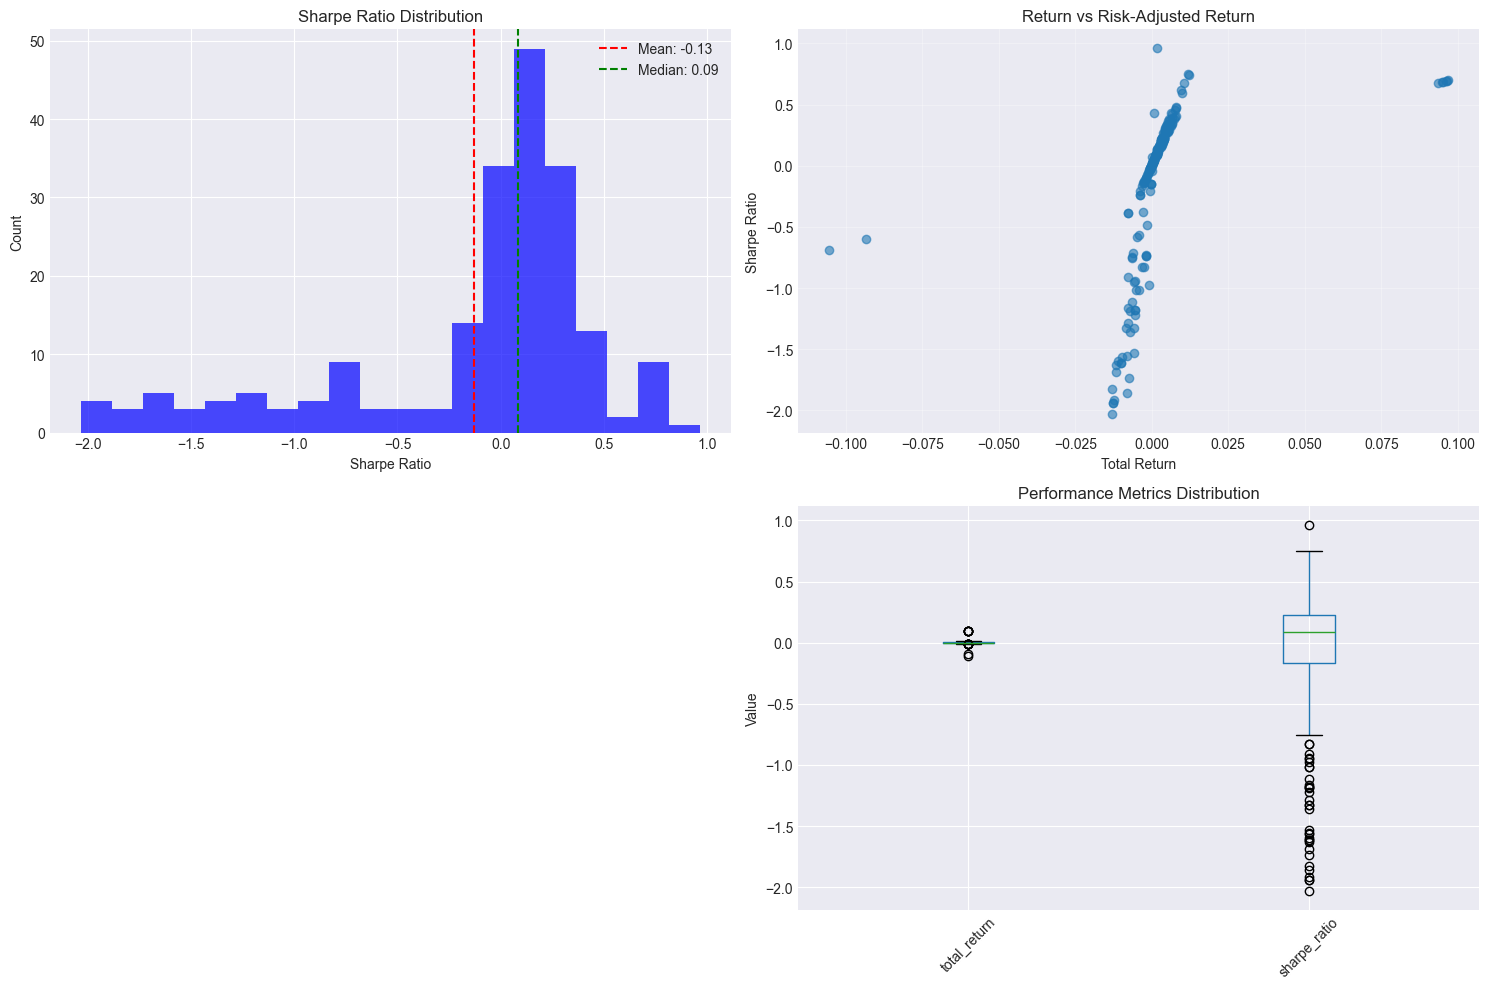

In [11]:
# Visualizations for single or multiple strategy types
if len(performance_df) > 0:
    if performance_df['strategy_type'].nunique() > 1:
        # Multiple strategy types - original visualization
        plt.figure(figsize=(14, 6))
        
        # Box plot of Sharpe by type
        plt.subplot(1, 2, 1)
        performance_df.boxplot(column='sharpe_ratio', by='strategy_type', ax=plt.gca())
        plt.xticks(rotation=45, ha='right')
        plt.title('Sharpe Ratio Distribution by Strategy Type')
        plt.suptitle('')  # Remove default title
        plt.ylabel('Sharpe Ratio')
        
        # Scatter: Return vs Sharpe
        plt.subplot(1, 2, 2)
        for stype in performance_df['strategy_type'].unique():
            mask = performance_df['strategy_type'] == stype
            plt.scatter(performance_df.loc[mask, 'total_return'], 
                       performance_df.loc[mask, 'sharpe_ratio'],
                       label=stype, alpha=0.6)
        plt.xlabel('Total Return')
        plt.ylabel('Sharpe Ratio')
        plt.title('Return vs Risk-Adjusted Return')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        # Single strategy type - parameter analysis visualization
        plt.figure(figsize=(15, 10))
        
        # 1. Sharpe ratio distribution
        plt.subplot(2, 2, 1)
        performance_df['sharpe_ratio'].hist(bins=20, alpha=0.7, color='blue')
        plt.axvline(performance_df['sharpe_ratio'].mean(), color='red', linestyle='--', label=f'Mean: {performance_df["sharpe_ratio"].mean():.2f}')
        plt.axvline(performance_df['sharpe_ratio'].median(), color='green', linestyle='--', label=f'Median: {performance_df["sharpe_ratio"].median():.2f}')
        plt.xlabel('Sharpe Ratio')
        plt.ylabel('Count')
        plt.title('Sharpe Ratio Distribution')
        plt.legend()
        
        # 2. Return vs Sharpe scatter
        plt.subplot(2, 2, 2)
        # Determine which parameters exist (check both naming conventions)
        param_cols = [col for col in performance_df.columns if col.startswith('param_')]
        direct_param_cols = ['period', 'std_dev', 'fast_period', 'slow_period', 'multiplier', 'exit_threshold']
        available_param_cols = [col for col in direct_param_cols if col in performance_df.columns]
        
        # Use direct parameter names if available, otherwise fall back to param_ prefix
        if available_param_cols:
            param_cols = available_param_cols
        
        if len(param_cols) >= 2:
            # Use first two parameters for visualization
            scatter = plt.scatter(performance_df['total_return'], 
                                 performance_df['sharpe_ratio'],
                                 c=performance_df[param_cols[0]], 
                                 cmap='viridis',
                                 s=performance_df[param_cols[1]]*50 if performance_df[param_cols[1]].max() < 10 else 50,
                                 alpha=0.6)
            plt.colorbar(scatter, label=param_cols[0].replace('param_', ''))
            plt.title(f'Return vs Risk-Adjusted Return\n(Color={param_cols[0].replace("param_", "")}, Size={param_cols[1].replace("param_", "")})')
        else:
            plt.scatter(performance_df['total_return'], 
                       performance_df['sharpe_ratio'],
                       alpha=0.6)
            plt.title('Return vs Risk-Adjusted Return')
        plt.xlabel('Total Return')
        plt.ylabel('Sharpe Ratio')
        plt.grid(True, alpha=0.3)
        
        # 3. Parameter heatmap (if enough data and two numeric parameters)
        if len(performance_df) > 10 and len(param_cols) >= 2:
            plt.subplot(2, 2, 3)
            try:
                # Create pivot table for heatmap
                pivot_sharpe = performance_df.pivot_table(
                    values='sharpe_ratio', 
                    index=param_cols[0], 
                    columns=param_cols[1],
                    aggfunc='mean'
                )
                if not pivot_sharpe.empty and pivot_sharpe.shape[0] > 1 and pivot_sharpe.shape[1] > 1:
                    sns.heatmap(pivot_sharpe, cmap='RdYlGn', center=0, 
                               cbar_kws={'label': 'Sharpe Ratio'})
                    plt.title(f'Sharpe Ratio by {param_cols[0].replace("param_", "")} and {param_cols[1].replace("param_", "")}')
            except:
                plt.text(0.5, 0.5, 'Not enough data for heatmap', 
                        ha='center', va='center', transform=plt.gca().transAxes)
        
        # 4. Box plot of returns
        plt.subplot(2, 2, 4)
        performance_df.boxplot(column=['total_return', 'sharpe_ratio'])
        plt.xticks(rotation=45)
        plt.title('Performance Metrics Distribution')
        plt.ylabel('Value')
        
        plt.tight_layout()
        plt.show()
        
        # Additional parameter analysis
        if param_cols:
            print("\n📈 Parameter Analysis:")
            for param in param_cols[:3]:  # Analyze first 3 parameters
                if param in performance_df.columns and performance_df[param].notna().any():
                    corr = performance_df[param].corr(performance_df['sharpe_ratio'])
                    param_display = param.replace('param_', '')
                    print(f"Correlation between {param_display} and Sharpe: {corr:.3f}")
            
            # Group by parameter ranges to find stable regions
            if len(param_cols) >= 2 and len(performance_df) > 20:
                print("\n🎯 Performance by Parameter Ranges:")
                try:
                    # Find numeric parameter columns
                    numeric_params = []
                    for col in param_cols:
                        if pd.api.types.is_numeric_dtype(performance_df[col]) and performance_df[col].notna().sum() > 0:
                            numeric_params.append(col)
                    
                    if len(numeric_params) >= 2:
                        # Create bins for numeric parameters
                        param1_groups = pd.cut(performance_df[numeric_params[0]], bins=5)
                        param2_groups = pd.cut(performance_df[numeric_params[1]], bins=5)
                        
                        param_summary = performance_df.groupby([param1_groups, param2_groups])['sharpe_ratio'].agg(['mean', 'std', 'count'])
                        param_summary = param_summary[param_summary['count'] > 0].sort_values('mean', ascending=False)
                        
                        # Display with clean parameter names
                        param1_name = numeric_params[0].replace('param_', '')
                        param2_name = numeric_params[1].replace('param_', '')
                        print(f"\nTop performing {param1_name} x {param2_name} ranges:")
                        print(param_summary.head(10))
                    else:
                        print("Not enough numeric parameters for range analysis")
                except Exception as e:
                    print(f"Could not create parameter range analysis: {e}")

## Correlation Analysis for Ensemble Building

In [12]:
def calculate_strategy_correlations(strategies_df, market_data, run_dir):
    """Calculate correlation matrix between strategies"""
    returns_dict = {}
    
    for idx, row in strategies_df.iterrows():
        try:
            # Use the global run_dir
            signals_path = run_dir / row['trace_path']
            signals = pd.read_parquet(signals_path)
            signals['ts'] = pd.to_datetime(signals['ts'])
            
            # Merge and calculate returns
            df = market_data.merge(signals[['ts', 'val']], left_on='timestamp', right_on='ts', how='left')
            df['signal'] = df['val'].ffill().fillna(0)
            df['returns'] = df['close'].pct_change()
            df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
            
            returns_dict[row['strategy_hash']] = df['strategy_returns']
        except:
            pass
    
    # Create returns DataFrame and calculate correlation
    if returns_dict:
        returns_df = pd.DataFrame(returns_dict)
        return returns_df.corr()
    return pd.DataFrame()

In [13]:
# Optimized correlation calculation with progress tracking
if len(performance_df) > 0 and len(top_overall) > 1:
    print("\n🔗 Calculating correlations among top strategies...")
    print(f"Processing {len(top_overall)} strategies...")
    
    # First, load all returns data in one pass
    returns_dict = {}
    
    for idx, (_, row) in enumerate(top_overall.iterrows()):
        if idx % 5 == 0:
            print(f"  Loading signals: {idx}/{len(top_overall)}")
            
        try:
            signals_path = run_dir / row['trace_path']
            
            # Load signals
            signals = pd.read_parquet(signals_path)
            signals['ts'] = pd.to_datetime(signals['ts'])
            
            # Merge with market data (already in memory)
            df = market_data.merge(
                signals[['ts', 'val']], 
                left_on='timestamp', 
                right_on='ts', 
                how='left'
            )
            df['signal'] = df['val'].ffill().fillna(0)
            
            # Calculate strategy returns only once
            df['returns'] = df['close'].pct_change()
            df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
            
            returns_dict[row['strategy_hash']] = df['strategy_returns'].values
        except Exception as e:
            print(f"  Warning: Could not load {row['strategy_hash'][:8]}: {e}")
    
    print(f"✅ Loaded returns for {len(returns_dict)} strategies")
    
    if len(returns_dict) >= 2:
        # Convert to DataFrame for correlation calculation
        returns_df = pd.DataFrame(returns_dict)
        
        # Calculate correlation matrix (this is fast once data is loaded)
        print("Calculating correlation matrix...")
        corr_matrix = returns_df.corr()
        
        # Find uncorrelated pairs
        uncorrelated_pairs = []
        n = len(corr_matrix)
        total_pairs = n * (n - 1) // 2
        
        pair_count = 0
        for i in range(n):
            for j in range(i+1, n):
                pair_count += 1
                    
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) < correlation_threshold:
                    uncorrelated_pairs.append({
                        'strategy1': corr_matrix.index[i],
                        'strategy2': corr_matrix.columns[j],
                        'correlation': corr_val
                    })
        
        print(f"✅ Found {len(uncorrelated_pairs)} uncorrelated pairs (correlation < {correlation_threshold})")
        
        # Visualize correlation matrix
        if len(corr_matrix) <= 20:
            plt.figure(figsize=(10, 8))
            # Only show annotations if matrix is small enough
            show_annot = len(corr_matrix) <= 10
            sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1, 
                       xticklabels=[h[:8] for h in corr_matrix.columns],
                       yticklabels=[h[:8] for h in corr_matrix.index],
                       annot=show_annot, fmt='.2f' if show_annot else None)
            plt.title('Strategy Correlation Matrix')
            plt.tight_layout()
            plt.show()
            
            # Show correlation statistics
            corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
            print(f"\nCorrelation Statistics:")
            print(f"  Mean correlation: {np.mean(corr_values):.3f}")
            print(f"  Median correlation: {np.median(corr_values):.3f}")
            print(f"  Min correlation: {np.min(corr_values):.3f}")
            print(f"  Max correlation: {np.max(corr_values):.3f}")
        else:
            print(f"Skipping heatmap visualization (too many strategies: {len(corr_matrix)})")
    else:
        print("❌ Not enough strategies loaded for correlation analysis")


🔗 Calculating correlations among top strategies...
Processing 10 strategies...
  Loading signals: 0/10
  Loading signals: 5/10
✅ Loaded returns for 1 strategies
❌ Not enough strategies loaded for correlation analysis


## Ensemble Recommendations

In [14]:
# Build optimal ensemble
if len(performance_df) > 0 and 'corr_matrix' in locals() and not corr_matrix.empty:
    # Start with best strategy
    ensemble = [top_overall.iloc[0]['strategy_hash']]
    ensemble_data = [top_overall.iloc[0]]
    
    # Add uncorrelated strategies
    for idx, candidate in top_overall.iloc[1:].iterrows():
        if len(ensemble) >= ensemble_size:
            break
            
        # Check correlation with existing ensemble members
        candidate_hash = candidate['strategy_hash']
        if candidate_hash in corr_matrix.columns:
            max_corr = 0
            for existing in ensemble:
                if existing in corr_matrix.index:
                    corr = abs(corr_matrix.loc[existing, candidate_hash])
                    max_corr = max(max_corr, corr)
            
            if max_corr < correlation_threshold:
                ensemble.append(candidate_hash)
                ensemble_data.append(candidate)
    
    print(f"\n🎯 Recommended Ensemble ({len(ensemble)} strategies):")
    print("=" * 80)
    
    ensemble_df = pd.DataFrame(ensemble_data)
    for idx, row in ensemble_df.iterrows():
        print(f"\n{idx+1}. {row['strategy_type']} - {row['strategy_hash'][:8]}")
        print(f"   Sharpe: {row['sharpe_ratio']:.2f} | Return: {row['total_return']:.1%}")
    
    # Calculate ensemble metrics
    print(f"\nEnsemble Statistics:")
    print(f"  Average Sharpe: {ensemble_df['sharpe_ratio'].mean():.2f}")
    print(f"  Average Return: {ensemble_df['total_return'].mean():.1%}")
    print(f"  Strategy Types: {', '.join(ensemble_df['strategy_type'].unique())}")

## Export Results

In [15]:
# Export recommendations
if len(performance_df) > 0:
    recommendations = {
        'run_info': {
            'run_id': run_dir.name,
            'config_name': config_name,
            'generated_at': datetime.now().isoformat(),
            'total_strategies': len(strategy_index) if strategy_index is not None else 0,
            'strategies_analyzed': len(performance_df)
        },
        'best_individual': {},
        'best_by_type': {},
        'ensemble': []
    }
    
    # Best overall
    if len(top_overall) > 0:
        best = top_overall.iloc[0]
        recommendations['best_individual'] = {
            'strategy_hash': best['strategy_hash'],
            'strategy_type': best['strategy_type'],
            'sharpe_ratio': float(best['sharpe_ratio']),
            'total_return': float(best['total_return']),
            'max_drawdown': float(best['max_drawdown']),
            'parameters': {col.replace('param_', ''): best[col] 
                          for col in best.index if col.startswith('param_') and pd.notna(best[col])}
        }
    
    # Best by type
    for stype in performance_df['strategy_type'].unique():
        type_best = performance_df[performance_df['strategy_type'] == stype].nlargest(1, 'sharpe_ratio')
        if len(type_best) > 0:
            row = type_best.iloc[0]
            recommendations['best_by_type'][stype] = {
                'strategy_hash': row['strategy_hash'],
                'sharpe_ratio': float(row['sharpe_ratio']),
                'total_return': float(row['total_return'])
            }
    
    # Ensemble
    if 'ensemble_df' in locals():
        for idx, row in ensemble_df.iterrows():
            recommendations['ensemble'].append({
                'strategy_hash': row['strategy_hash'],
                'strategy_type': row['strategy_type'],
                'sharpe_ratio': float(row['sharpe_ratio']),
                'weight': 1.0 / len(ensemble_df)  # Equal weight for now
            })
    
    # Save files
    with open(run_dir / 'recommendations.json', 'w') as f:
        json.dump(recommendations, f, indent=2)
    
    performance_df.to_csv(run_dir / 'performance_analysis.csv', index=False)
    
    print("\n✅ Results exported:")
    print(f"  - recommendations.json")
    print(f"  - performance_analysis.csv")
else:
    print("⚠️ No results to export")


✅ Results exported:
  - recommendations.json
  - performance_analysis.csv


## Additional Analysis with Snippets

You can now extend this analysis using pre-built snippets. Examples:

### Exploratory Analysis
```python
%load src/analytics/snippets/exploratory/signal_frequency.py
# Then edit parameters and run

%load src/analytics/snippets/exploratory/parameter_sweep.py
# Analyze specific strategy type parameters
```

### Ensemble Building
```python
%load src/analytics/snippets/ensembles/find_uncorrelated.py
# Advanced correlation analysis

%load src/analytics/snippets/ensembles/optimize_weights.py
# Optimize portfolio weights
```

### Regime Analysis
```python
%load src/analytics/snippets/regime/volatility_regimes.py
# Performance in different volatility environments
```

### Helper Functions
```python
%load src/analytics/snippets/helpers.py
# Load utility functions for custom analysis
```

Each snippet contains editable parameters at the top. Modify them before running to customize the analysis.

## Summary

Analysis complete! Key files generated:
- `recommendations.json` - Best strategies and ensemble recommendations
- `performance_analysis.csv` - Full performance data for all strategies

Next steps:
1. Use the recommended ensemble for live trading
2. Deep dive into specific strategy types if needed
3. Run regime-specific analysis to understand performance drivers